In [54]:
import pandas as pd
import numpy as np
import random
import math
import gc
from collections import defaultdict
import matplotlib.pylab as plt
import networkx as nx
from copy import deepcopy

In [40]:
num_vertices = 25
edges = []
vertices = list(range(num_vertices))
# Initialize adjacency matrix
def init_adjacency_matrix(nodes, edges):
    adjacency_matrix = np.zeros((nodes,nodes),dtype = np.int)

    edge_probability = .0085 if nodes > 100 else 0.09


    edges_cnt = 0
    for i in range(nodes):
        for j in range(i):
            prob = random.random()
            if prob < edge_probability:
                adjacency_matrix[i,j] = 1
                edges.append((i,j))
                edges_cnt += 1

    return adjacency_matrix
adjacency_matrix = init_adjacency_matrix(num_vertices, edges)

In [41]:
G=nx.Graph()
G.add_nodes_from(list(range(0,num_vertices)))
G.add_edges_from(edges)

C:\Users\shriv\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


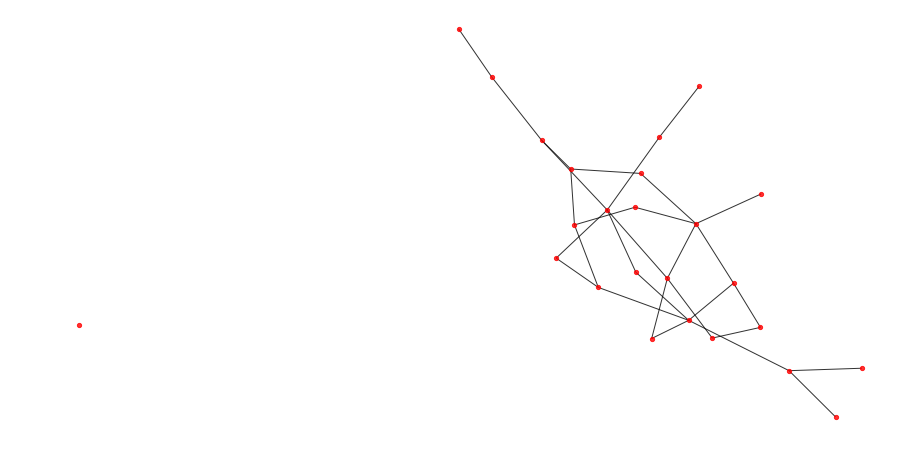

In [42]:
plt.figure(figsize=(12,6))
nx.draw(G,node_color='r', node_size=18, alpha=0.8)
plt.show() # display

In [52]:
# Initialize variables and constants
num_ants = 10
ant_dict = {ant: [0, 0] for ant in range(num_ants)} # ant: (curr_vertex, num_of_vertices_visited)
vertex_weights = {node:1 for node in range(num_vertices)}
tau_o = random.random() 
solution_set = []
q_o = 0.5
alpha = 0.1
psi = 0.3

In [44]:
# Helpers
def get_adjacent_vertices(vertex):
    vertices = []
    for vert in adjacency_matrix[vertex]:
        if vert > 0:
            vertices.append(vert)
            
    return vertices

def get_arg_max_phermone(vertex_values):
    arg_max = []
    max_val = -1
    for vertex, value in vertex_values.items():
        if value > max_val:
            max_val = value
            arg_max = [vertex]
            
        elif value == max_val:
            arg_max.append(vertex)
            
    return arg_max

In [50]:
vertex_phermones = {node:tau_o for node in range(num_vertices)}
vertex_values = {node: vertex_phermones[node]*get_eta_k(node)**alpha for node in range(num_vertices)}


In [57]:
def get_psi_k(vertex_i, vertex_j):
    return adjacency_matrix[vertex_i][vertex_j]

# Eta function
def get_eta_k(vertex):
    total_edges = sum([get_psi_k(vertex_i,vertex_j) for vertex_i in range(num_vertices) for vertex_j in range(num_vertices)])
    weight_vertex = vertex_weights[vertex]
    return total_edges/weight_vertex

# Probability
def get_transition_probabilty(vertex_j, vertex_i, q_o=q_o, available_vertices = None):
    
    # vertex_j is current vertex and vertex_i is adjacent vertex
    q = random.random()
    
    if q <=q_o:
        tau_j = get_tau(vertex_j, vertex_phermones[vertex_j])
        eta_j_k = (get_eta_k(vertex_j))**alpha
        if not available_vertices:
            available_vertices = get_adjacent_vertices(vertex_j)
        denominator = sum([tau_j*get_eta_k(vert) for vert in available_vertices])
        return tau_j*eta_j_k / denominator
    
    arg_max = get_arg_max_phermone(vertex_values)
    
    if vertex_i in arg_max:
        return 1
    return 0
        

# Local update rule
def get_local_tau_j(vertex_j):
    return (1-psi)*vertex_phermones[vertex_j] + psi*tau_o
    
# Global update rule 
def get_delta_tau_j():
    return 1/(sum(vertex_weights(vertex_j) for vertex_j in solution_set))
    
def get_tau(vertex_i, local_phermone):
    delta_tau = get_delta_tau_j()
    tau = (1-get_transition_probabilty(vertex_i))*(local_phermone+vertex_phermones[vertex_i]) + delta_tau # We update based on local and current global phermones
    return tau

def update_eta_k(vertex, available_vertices = None):
    if not available_vertices:
        available_vertices = get_adjacent_vertices(vertex)
    vertex_values[vertex] = (vertex_phermones[node]*get_eta_k(node)**alpha for node in available_vertices)
    return 
        
        
# Change this function
def all_ants_finished():
    all_ants_finished = False
    for (curr_vertex, num_vertices_visited) in ant_dict.values():
        all_ants_finished = all_ants_finished and (num_vertices_visited == num_vertices)
        
    if all_ants_finished:
        print("All ants finished")
    return all_ants_finished

In [58]:
def OptCover(start_index, connections, covered, total_sum):
    best_value = 0
    if start_index >= num_vertices:
        return
    if total_sum > best_value:
        return
    if covered == num_vertices:
        best_value = max(best_value, total_sum)
        return
    
    
def start_ACO(adjacency_matrix):
    local_phermone_dict = defaultdict(int)
    while not all_ants_finished():
        local_phermone_dict = defaultdict(int) # vertex: phermone used to sotre local phermone status
        for ant, (curr_vertex, num_vertices_visited) in ant_dict.items():
            if num_vertices_visited != num_vertices: # Ant has not visited all vertices; ant is not finished
                random_prob =  random.random()
                available_vertices = get_adjacent_vertices(curr_vertex)
                for adj_vertex in available_vertices:
                    if adj_vertex in solution_set:
                        continue
                    prob = get_transition_probabilty(curr_vertex, adj_vertex, available_vertices=available_vertices)
                    if random_prob <= prob:
                        solution_set.append(adj_vertex)
                        ant_dict[ant] = [adj_vertex, num_vertices_visited+1]
                        
                        # Update adjacency matrix
                        adjacency_matrix[adj_vertex] = [0]*len(num_vertices)
                        for row in range(num_vertices):
                            adjacency_matrix[row][adj_vertex] = 0
                            
                        # Update local phermone
                        local_phermone_val = get_local_tau_j(adj_vertex)
                        local_phermone_dict[adj_vertex] += local_phermone_val
                        
                        # Update eta 
                        update_eta_k(adj_vertex) 
                        break
        for vertex, local_phermone in local_phermone_dict.items():
            
            # Not sure if this should be local or global
            vertex_phermones[vertex] =  get_tau(vertex, local_phermone) # This function uses local and global phermones for update
    return solution_set    
                    
def ACO():
    #Reset adjacency matrix and graph info
    vertices_copy = deepcopy(vertices)
    count = 0
    #lines 19-38 need to be iterated
    finished = all_ants_finished()
    if not finished:
        while count != 1:
            for curr_vertex in vertices_copy:
                if not (curr_vertex in solution_set):
                    # Add based on probaility
                    solution_set.append(curr_vertex)
                else:
                    if len(solution_set) >= len(vertices):
                        break
                    else:
                        continue
            get_adjacent_vertices(adjacency_matrix, curr_vertex)
            count += 1
    prob = get_transition_probabilty(adjacency_matrix, curr_vertex, q_o=q_o)
    get_local_tau_j(curr_vertex)
    get_delta_tau_j()
    finished = all_ants_finished()
    